In [63]:
import numpy as np
import scipy
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import nltk
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from bs4 import BeautifulSoup
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain

In [194]:
post = pd.read_csv('Data/SOF_Questions.csv')
tags = pd.read_csv('Data/SOF_Tags.csv')
post_type = pd.read_csv('Data/SOF_PostType.csv')
tag_synonyms = pd.read_csv('Data/SOF_Tag_Synonyms.csv')
assoc_post_tags = pd.read_csv('Data/SOF_assoc_Post_Tags.csv')

## Fonctions

In [4]:
def post_to_words( post_text, stopwords_lem=True, html=True):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and
    # the output is a single string (a preprocessed movie review)
    if html:
        post_text = BeautifulSoup(post_text).get_text()
        # 1. Remove HTML
    # 2. Remove non-letters
    #post_text = re.sub("[^a-zA-Z]", " ", post_text)
    post_text = re.sub(r"(\\n)|(\.\\n)|[;/\\\{}()*`':=\"|!?\[\]]", " ", post_text)
    post_text = re.sub(r"(\.\s)|(\.$)|(,\s)|(\s#\s)|(<\s)|(\s>)|(\s\-\s)|(\s-?\+?\d*\s)|(\s\W{1,4}\s)", " ", post_text)
    post_text = re.sub(r"\s+", " ", post_text)
    #
    # 3. Convert to lower case, split into individual words
    words = post_text.lower().split()
    #
    if stopwords_lem :
        # 4. In Python, searching a set is much faster than searching
        # a list, so convert the stop words to a set
        stops = set(stopwords.words("english"))
        # 5. Remove stop words
        words = [w for w in words if not w in stops]
        # 6. Join the words back into one string separated by space,
        # and return the result.
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join( words )

In [5]:
def add_tags_column(row):
    row['Tags_list'] = " ".join(df_tags[df_tags['PostId'] == row['Id_Post']].TagName.values)
    return row

In [6]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [351]:
# Download the punkt tokenizer for sentence splitting
import nltk.data

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, stopwords_lem=False ):
    # Function to split a review into parsed sentences. Returns a
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( post_to_words( raw_sentence, stopwords_lem ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

## De Cotée

In [ ]:
forest = RandomForestClassifier(n_jobs=-1)
clfc = ClassifierChain(forest)
clfc.fit(x_train_tfidf, y_train_tfidf)

ClassifierChain(base_estimator=RandomForestClassifier(n_jobs=-1))

In [ ]:
forest = RandomForestClassifier()
clf = MultiOutputClassifier(forest, n_jobs=-1)
clf.fit(x_train_tfidf, y_train_tfidf)
Y_Pred = clf.predict(x_test_tfidf)

In [ ]:
forest = RandomForestClassifier()
clf = OneVsRestClassifier(forest, n_jobs=-1)
clf.fit(x_train_tfidf, y_train_tfidf)
Y_Pred = clf.predict(x_test_tfidf)

In [ ]:
forest = RandomForestClassifier()
clf = OneVsRestClassifier(forest, n_jobs=-1)
y_score = clf.fit(x_train_tfidf, y_train_tfidf).decision_function(x_test_tfidf)

AttributeError: This 'OneVsRestClassifier' has no attribute 'decision_function'

## Préparation

### Tags

In [188]:
tags['Count_log'] = np.log10(tags['Count'])
best_tags = tags[tags['Count_log'] > 4]
best_tags.dropna(inplace=True)
df_tags = assoc_post_tags.merge(best_tags, left_on='TagId', right_on='Id')
df_tags.dropna(inplace=True)

C:\Users\Jayma\AppData\Local\Temp\ipykernel_12740\2190344551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_tags.dropna(inplace=True)


### Post

In [189]:
post = post.merge(post_type, left_on='PostTypeId', right_on='Id', suffixes=('_Post', '_PostType'))
post[['Body', 'Title', 'Tags']].astype(str)
post['Title'].fillna("", inplace=True)
post.drop(['Id_PostType', 'PostTypeId'], axis=1, inplace=True)
post.rename(columns={'Name': 'PostType'}, inplace=True)
post['Body_clean'] = post['Body'].apply(lambda x: post_to_words(x))
post['Title_clean'] = post['Title'].apply(lambda x: post_to_words(x, html=False))
post['Text'] = post['Title_clean'] + " " + post['Body_clean']
post = post.apply(add_tags_column, axis=1)
post = post[post['Tags_list'] != '']

In [204]:
post = post.apply(add_tags_column, axis=1)
post.shape

(50000, 11)

In [191]:
questions = post[post['PostType'] == 'Question']
questions = questions[['Text', 'Tags_list']]
questions['Tags'] = questions['Tags_list'].str.split()

In [211]:
post[post['PostType'] == "Answer"]['Tags_list']

9757      
9758      
9759      
9760      
9761      
        ..
49995     
49996     
49997     
49998     
49999     
Name: Tags_list, Length: 40243, dtype: object

## Supervisé

In [180]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(post.Tags)
Y = multilabel_binarizer.transform(post.Tags)

count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=10000)
X_counts = count_vect.fit_transform(post.Text)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [181]:
tSVD = TruncatedSVD(n_components=100)
X_Tsvd = tSVD.fit_transform(X_tfidf)

In [182]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
  X_Tsvd, Y, test_size=0.2, random_state=9000)

In [184]:
x_train_tfidf.shape

(7284, 100)

In [186]:
questions.shape

(9106, 3)

In [183]:
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(x_train_tfidf, y_train_tfidf)

RandomForestClassifier(n_jobs=-1)

In [170]:
Y_Prob = forest.predict_proba(x_test_tfidf)
Y_Proba = []
for i in Y_Prob:
    Y_Proba.append(i[:,0])
Y_Proba = 1 - np.array(Y_Proba).T

In [171]:
n_classes = Y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_tfidf[:, i], Y_Proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_tfidf.ravel(), Y_Proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn

In [176]:
roc_curve(y_test_tfidf[:, i], Y_Proba[:, i])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


(array([0.        , 0.00109769, 0.00164654, 0.01427003, 0.08671789,
        1.        ]),
 array([nan, nan, nan, nan, nan, nan]),
 array([1.05, 0.05, 0.04, 0.02, 0.01, 0.  ]))

In [172]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

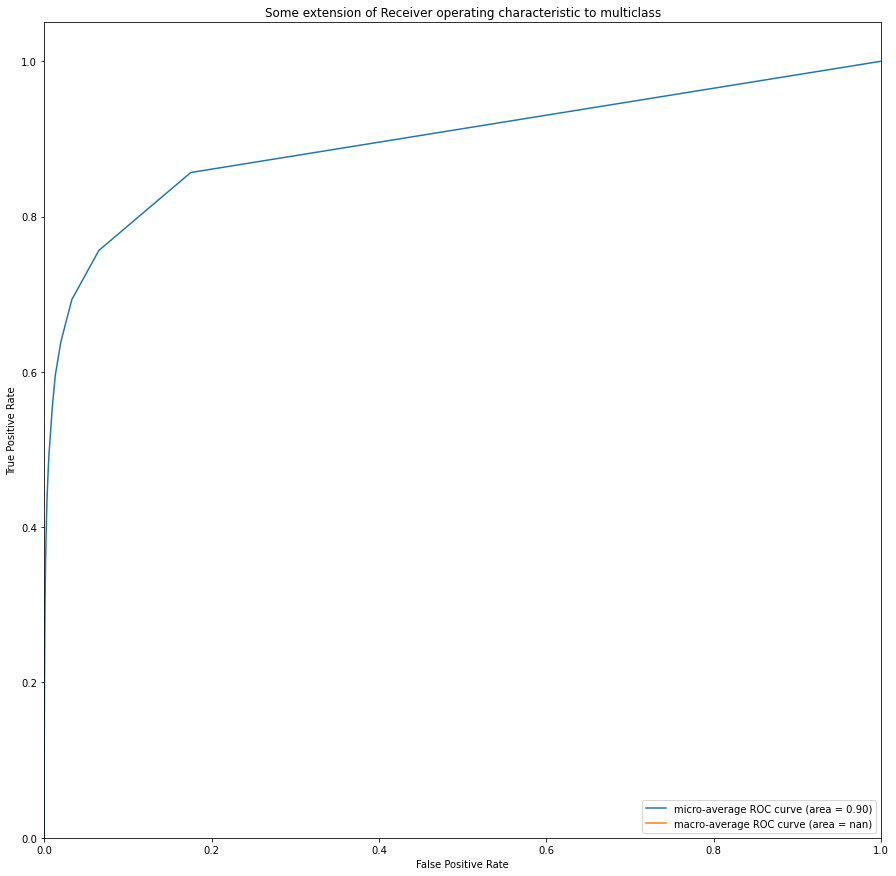

In [179]:
# Plot all ROC curves

plt.figure(figsize=[15,15])
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"])
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"])
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [144]:
Y_Proba.T

(1822, 516)

In [143]:
y_test_tfidf.shape

(1822, 516)

In [164]:
fpr, tpr, _ = roc_curve(y_test_tfidf[:,2], Y_Proba[:,2])

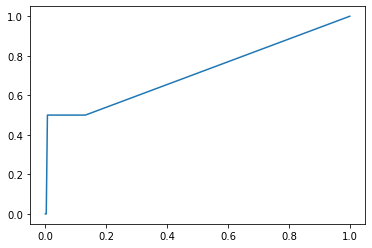

In [165]:
plt.plot( fpr, tpr)

In [84]:
Y_Pred = forest.predict(x_test_tfidf)

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [120]:
roc_curve(y_test[:, i], y_score[:, i])

ValueError: Found input variables with inconsistent numbers of samples: [75, 1822]

In [119]:
n_classes = Y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ValueError: Found input variables with inconsistent numbers of samples: [75, 1822]

In [118]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(x_train_tfidf, y_train_tfidf).decision_function(x_test_tfidf)
n_classes = y.shape[1]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 57 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 67 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 181 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 290 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 294 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:79: UserWarning: Label not 309 is pres

ValueError: Found input variables with inconsistent numbers of samples: [75, 1822]

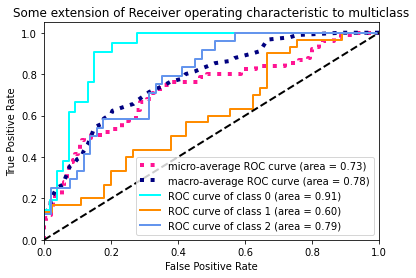

In [117]:
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [12]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'functional', 
                                        1: 'needs repair', 
                                        2: 'nonfunctional'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [24]:
plot_ROC_curve(clf, x_train_tfidf, y_train_tfidf, x_test_tfidf, y_test_tfidf)

YellowbrickValueError: ROCAUC does not support target type 'multilabel-indicator', please provide a binary or multiclass single-output target

In [89]:
mcm = multilabel_confusion_matrix(y_test_tfidf, Y_Pred)
tn = mcm[:, 0, 0].mean()
tp = mcm[:, 1, 1].mean()
fn = mcm[:, 1, 0].mean()
fp = mcm[:, 0, 1].mean()

In [90]:
[[tn,fn], [fp, tp]]

[[1814.4515503875969, 6.903100775193798],
 [0.06976744186046512, 0.5755813953488372]]

In [91]:
tp / (tp + fp)

0.8918918918918919

In [92]:
tp / (tp + fn)

0.0769629437678155

In [67]:
tot = tn + fn + fp + tp

In [68]:
tp + fp

0.8601941747572815

In [69]:
tp + fn

7.493203883495146

In [62]:
clfc.score(x_test_tfidf, y_test_tfidf)

0.04610318331503842

In [49]:
y_test_tfidf.shape

(1822, 515)

In [245]:
bag_of_word.vocabulary_

{'convert': 13788,
 '': 0,
 'decimal': 15375,
 'double': 16676,
 'c#': 11405,
 'want': 44138,
 'use': 43167,
 'track-bar': 41953,
 'change': 12044,
 'form': 19636,
 'opacity': 30266,
 'code': 12647,
 'trans': 41987,
 'trackbar1.value': 41956,
 '5000': 4511,
 'this.opacity': 41292,
 'build': 11205,
 'application': 9090,
 'give': 20656,
 'following': 19432,
 'error': 17866,
 'cannot': 11661,
 'implicitly': 22683,
 'type': 42364,
 'tried': 42164,
 'using': 43346,
 'control': 13725,
 'work': 44862,
 'worked': 44887,
 'fine': 19121,
 'past': 31502,
 'vb.net': 43640,
 'project': 33076,
 'width': 44566,
 'collapse': 12751,
 'percentage': 31708,
 'child': 12203,
 'element': 17346,
 'absolutely': 7879,
 'positioned': 32379,
 'parent': 31354,
 'internet': 23447,
 'explorer': 18395,
 '7': 4780,
 'div': 16321,
 'containing': 13615,
 'several': 36983,
 'one': 30149,
 'relatively': 34597,
 'percentage-based': 31709,
 '0': 2279,
 'ie7': 22364,
 'firefox': 19155,
 'safari': 35843,
 'pixel': 32065,
 's

## Test 1

In [27]:
bag_of_word = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=10000)
bag_of_word.fit(questions['Text'].values.tolist())
X_bag = bag_of_word.transform(questions['Text'].values.tolist())
text_tf_idn = TfidfTransformer()
text_tf_idn.fit(X_bag)
X_tf = text_tf_idn.transform(X_bag)

In [16]:
n_topics = 20

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0,
        n_jobs=-1)
# Fitter sur les données
lda.fit(X_bag)


# Run NMF
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(X_tf)

NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=20, random_state=1)

In [17]:
pyLDAvis.sklearn.prepare(lda, X_bag, bag_of_word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.220733  0.073755       1        1  34.751098
17     0.223943  0.084405       2        1  11.247733
16     0.229380  0.121448       3        1  10.549587
4      0.215615 -0.055745       4        1   7.416118
19     0.186657 -0.201741       5        1   7.360326
8      0.221599  0.101971       6        1   6.626882
0      0.157346 -0.115831       7        1   5.760207
9      0.180278  0.111139       8        1   4.582987
18    -0.026972 -0.325654       9        1   2.505407
10     0.014069 -0.032174      10        1   2.217501
5     -0.098677 -0.034560      11        1   1.235830
6     -0.100404  0.108390      12        1   1.116067
7     -0.126165 -0.123926      13        1   0.849149
2     -0.160430  0.011403      14        1   0.829347
12    -0.171941  0.049716      15        1   0.602265
13    -0.186801  0.055356      16        1   0.550853
11    -0.191347  0.047256      17        1   0.480367
15    -0.193103  0.013425      18        1   0.463527
3     -0.199029  0.052025      19        1   0.437225
1     -0.194749  0.059342      20        1   0.417525, topic_info=            Term         Freq        Total Category  logprob  loglift
2037       class  2366.000000  2366.000000  Default  30.0000  30.0000
8856        test  1146.000000  1146.000000  Default  29.0000  29.0000
3726        file  3993.000000  3993.000000  Default  28.0000  28.0000
2664    database  1848.000000  1848.000000  Default  27.0000  27.0000
8747       table  1449.000000  1449.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4674    indexing    16.116165    23.664344  Topic20  -4.8924   5.0944
7492  resolution    24.413318    49.736955  Topic20  -4.4771   4.7670
2918         dev    24.290000   135.540142  Topic20  -4.4822   3.7594
3771      finish    12.160646    28.288062  Topic20  -5.1740   4.6343
5288       linux    12.423712   467.629746  Topic20  -5.1526   1.8505

[1125 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
16        2  0.992702  #include
69        9  0.894878    $field
77        5  0.053183        $i
77       15  0.904104        $i
78        5  0.966330       $id
...     ...       ...       ...
9994     16  0.969733     ‘asm’
9995     16  0.985620    ‘unary
9996      2  0.092748         ’
9996      4  0.015458         ’
9996     16  0.881104         ’

[2455 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 18, 17, 5, 20, 9, 1, 10, 19, 11, 6, 7, 8, 3, 13, 14, 12, 16, 4, 2])

In [ ]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(questions['Text'].values.tolist())
print(dtm_tf.shape)

In [302]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(questions['Text'].values.tolist())
print(dtm_tfidf.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1805: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "


(9106, 3458)


In [303]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=20, random_state=0)

In [306]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7     -0.121121 -0.052967       1        1  8.477048
15     0.010787 -0.090182       2        1  8.143703
0      0.052540  0.085915       3        1  7.713408
10     0.070819  0.072736       4        1  6.346808
16     0.140892 -0.111445       5        1  6.034989
12     0.109483 -0.172987       6        1  6.014311
1      0.044329  0.071259       7        1  5.301357
9      0.162167 -0.070371       8        1  5.209381
14     0.159262  0.006753       9        1  5.153294
6     -0.122200  0.026916      10        1  4.820757
13    -0.168595 -0.048842      11        1  4.797513
5     -0.175148 -0.037694      12        1  4.600593
8     -0.010247  0.215618      13        1  4.283463
19    -0.062834 -0.111473      14        1  4.127095
4      0.084749 -0.088768      15        1  4.114257
18    -0.231056 -0.031488      16        1  3.720319
11    -0.068133  0.006652      17        1  3.648246
17     0.027082  0.025820      18        1  2.916007
2      0.096273  0.105749      19        1  2.611250
3      0.000951  0.198799      20        1  1.966199, topic_info=             Term         Freq        Total Category  logprob  loglift
1621         java  1707.000000  1707.000000  Default  30.0000  30.0000
2749       server  2905.000000  2905.000000  Default  29.0000  29.0000
1149         file  4231.000000  4231.000000  Default  28.0000  28.0000
435         class  2365.000000  2365.000000  Default  27.0000  27.0000
707      database  1895.000000  1895.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
135   application    88.797632  2817.116313  Topic20  -4.5524   0.4720
1728         line    73.793751  1170.380223  Topic20  -4.7375   1.1653
2650          run    56.830283  1251.295736  Topic20  -4.9987   0.8372
3274        using    62.742256  4232.138838  Topic20  -4.8997  -0.2824
3349          way    61.214254  3956.118501  Topic20  -4.9244  -0.2396

[1280 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3         1  0.118118     abort
3         9  0.826829     abort
6         1  0.939796  abstract
6        17  0.009998  abstract
6        18  0.039991  abstract
...     ...       ...       ...
3452     16  0.861531      yyyy
3453     10  0.980900      zend
3456     15  0.777824      zone
3456     16  0.102345      zone
3456     18  0.102345      zone

[5344 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 16, 1, 11, 17, 13, 2, 10, 15, 7, 14, 6, 9, 20, 5, 19, 12, 18, 3, 4])

In [20]:
questions['Tags'][8]

['unix', 'algorithm', 'performance']

In [284]:
no_top_words = 10
display_topics(lda, bag_of_word.get_feature_names(), no_top_words)

Topic 0:
ruby error lib usr 5.8 ’ hash ‘ gem file
Topic 1:
email path send message address socket font sending outlook mail
Topic 2:
test class testing unit session end rail interface def method
Topic 3:
object class function type code new like get way method
Topic 4:
linux cs core width div style height cpu space div>
Topic 5:
database sql table data server query column select stored row
Topic 6:
string array + b character byte c char branch convert
Topic 7:
dialog src jrst-0.8.1 11-30-07 http js.js>< script><script messagebox window www.uhwc.ru
Topic 8:
1 0 3 2 n int 0-9 4 regex number
Topic 9:
tomcat servlet unknown www.example.com applicationfilterchain.java 25 source 2d sep 46
Topic 10:
resolution mongrel_r 11628 retcode questionnaire 0,8 potion perldoc @raw_num long
Topic 11:
customizabletable sp b0 car 28-aug-2008 crystal sp_cursorfetch vehicle depression 180150003,32,1,1
Topic 12:
exception error thread debug catch assembly throw video try contact
Topic 13:
text name button val

In [292]:
no_top_words = 10
display_topics(nmf, bag_of_word.get_feature_names(), no_top_words)

Topic 0:
like would code use way using one know get need
Topic 1:
table database data column row query mysql select sql field
Topic 2:
class public method static private void name interface property return
Topic 3:
file xml directory path folder open line copy log script
Topic 4:
page javascript html browser cs content link web button tag
Topic 5:
visual studio 2008 2005 v c++ build solution ide express
Topic 6:
.net framework 2.0 3.5 c# application assembly sp1 version library
Topic 7:
server sql 2005 database procedure stored query linq 2000 connection
Topic 8:
php mysql script apache echo variable zend site way session
Topic 9:
test unit testing run framework nunit integration write mock code
Topic 10:
string value array return function convert int 1 0 name
Topic 11:
control form property event source button textbox custom version wpf
Topic 12:
window application xp form linux o vista mac machine process
Topic 13:
object type property collection method new return reference create se

## Visualisation

In [244]:
bag_of_word = CountVectorizer(lowercase=False, token_pattern="\S+")
bag_of_word.fit(questions['Text'].values.tolist())
X_bag = bag_of_word.transform(questions['Text'].values.tolist())
text_tf_idn = TfidfTransformer()
text_tf_idn.fit(X_bag)
X_tf = text_tf_idn.transform(X_bag)

In [256]:
tSVD = TruncatedSVD(n_components=3)
X_acp = tSVD.fit_transform(X_tf)

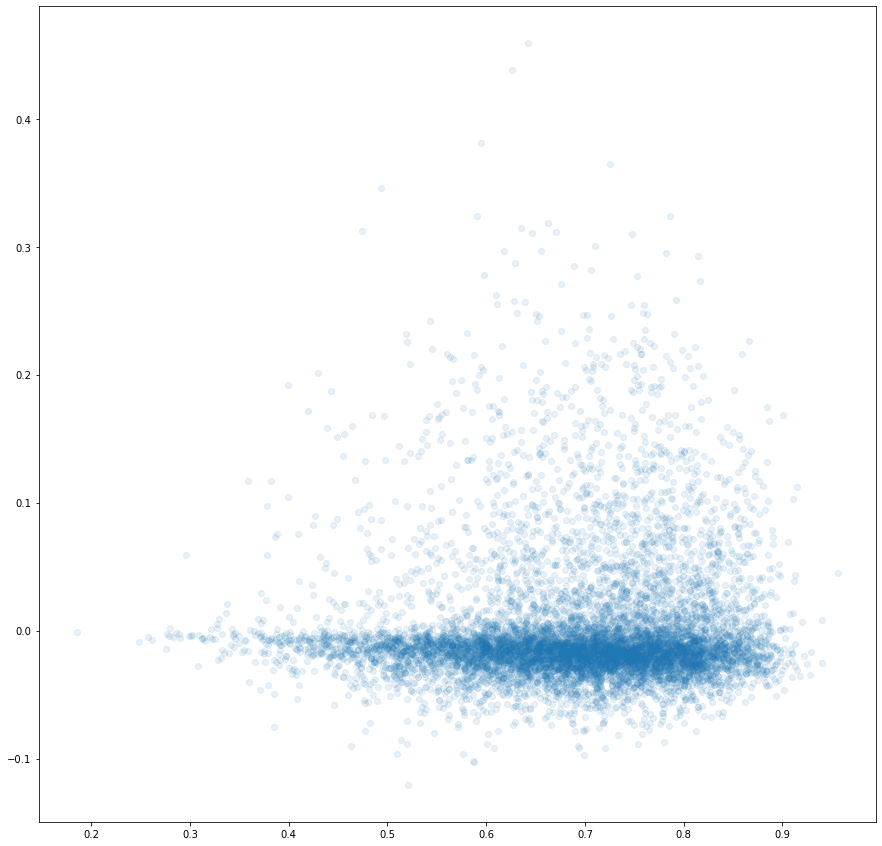

In [257]:
plt.figure(figsize=(15,15))
plt.scatter(X_acp[:,0], X_acp[:,1],alpha=0.1)

In [97]:
tags_tf_idn = TfidfVectorizer(lowercase=False)
tags_tf_idn.fit(questions['Tags_list'])
y_tf = tags_tf_idn.transform(questions['Tags_list'])

In [98]:
tSVD = TruncatedSVD(n_components=3)
y_acp = tSVD.fit_transform(y_tf)

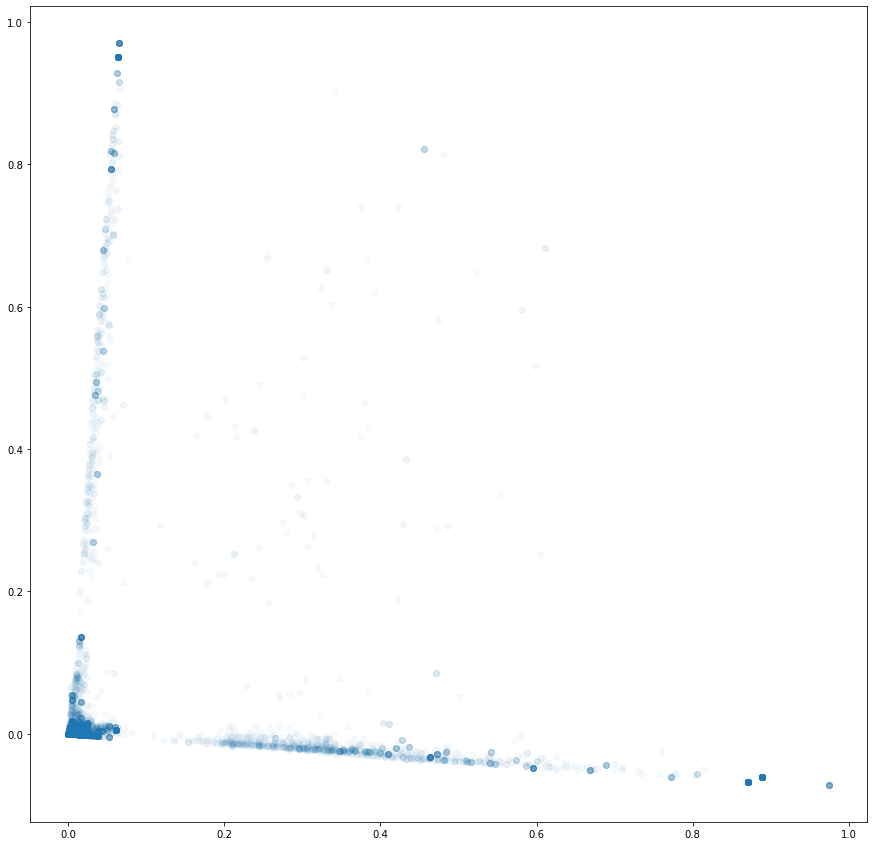

In [99]:
plt.figure(figsize=(15,15))
plt.scatter(y_acp[:,0], y_acp[:,1],alpha=0.03)